In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects
from tensorflow.keras.datasets import cifar10 as cifar10

## for Model definition/training
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, Nadam, Adadelta,SGD
from tensorflow.keras import regularizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns


In [3]:
base_dir = 'YouTube Data/'

# data loader

In [53]:
import os


id1= len(os.listdir(base_dir+'/1'))
id2 = len(os.listdir(base_dir+'/2'))
id3 = len(os.listdir(base_dir+'/3'))
id4 = len(os.listdir(base_dir+'/4'))
# id5 = len(os.listdir(base_dir+'/A'))
# id6 = len(os.listdir(base_dir+'/B'))
# id7=len(os.listdir(base_dir+'/C'))
# id8=len(os.listdir(base_dir+'/D'))
# id5 = len(os.listdir(base_dir+'/E'))
# id6 = len(os.listdir(base_dir+'/F'))
# id7=len(os.listdir(base_dir+'/G'))
# id8=len(os.listdir(base_dir+'/H'))

print('total id1:', id1)
print('total id2 :',id2)
print('total id3 :', id3)
print('total id4 :', id4)
# print('total id5 :', id5)
# print('total id6 :', id6)
# print('total id7 :', id7)
# print('total id8 :', id8)

# total_data = id1+id2+id3+id4
# print(total_data)


# The data, split between train and test sets
datagen = ImageDataGenerator(
#             rotation_range=45,
#             horizontal_flip=True,
#             vertical_flip=True,
#             rescale=1/255, 
#             zoom_range=1.2,
#             validation_split=0.2
) #Dataset dibagi menjadi 75% train set dan 25% validation set.

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(180, 80),
    batch_size=100000,
    class_mode='binary',
    subset='training',
    shuffle=True,
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(180, 80),
    batch_size=10000,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

total id1: 102
total id2 : 325
total id3 : 330
total id4 : 318
Found 2340 images belonging to 8 classes.
Found 0 images belonging to 8 classes.


In [54]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.tensorflow import balanced_batch_generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x_train, y_train = next(train_generator)
# x_test, y_test = next(validation_generator)
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_train = y_train.astype('uint8')
# y_test = y_test.astype('uint8')
# # x_train /= 255.
# # x_test /= 255.
# x_val = x_test
# y_val = y_test

In [6]:
x_train.shape

(2340, 180, 80, 3)

In [55]:
from sklearn.model_selection import train_test_split
# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy='majority')
# # fit and apply the transform
# x_train, y_train = undersample.fit_resample(x, y_train)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [56]:

input_image_shape = (x_train.shape[1], x_train.shape[2], 3)

## Balanced Data Generator

In [57]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.tensorflow import balanced_batch_generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(horizontal_flip=True,rotation_range=10,brightness_range=[0.2,1.0])
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [58]:

balanced_gen = BalancedDataGenerator(x_train, y_train, datagen, batch_size=32)
balanced_gen_val = BalancedDataGenerator(x_val, y_val, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch

# MODEL

In [59]:
import tensorflow_addons as tfa

def create_model(image_input_shape,embedding_size):

    decay = 0.000001
    input_image = tf.keras.layers.Input(shape=image_input_shape)

#     x = Conv2D(16,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
#                 activity_regularizer=regularizers.l2(decay))(input_image)
#     x = BatchNormalization()(x)
#     x = MaxPool2D(pool_size=(2, 2))(x)
#     x = Conv2D(16,(3,3),padding='same', activation='relu',kernel_regularizer=regularizers.l2(decay),
#                 activity_regularizer=regularizers.l2(decay))(x)
#     x = BatchNormalization()(x)
#     x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(32,(3,3),padding='same', activation='relu')(input_image)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(32,(3,3),padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(32,(5,5),padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(32,(5,5),padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(64,(3,3),padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(64,(3,3),padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='selu')(x)
    x = Dropout(0.1)(x)
    x = Dense(embedding_size)(x)
    
#     x = Dense(8, activation="softmax")(x)
#     x = tf.math.l2_normalize(x, axis=1)
    
    return tf.keras.models.Model(inputs=input_image, outputs=x)         

In [60]:

embedding_size =128
model = create_model(input_image_shape,embedding_size)
model.compile(loss=tfa.losses.triplet_semihard_loss, optimizer=Adam(0.001))
# model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.summary()

Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 180, 80, 3)]      0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 180, 80, 32)       896       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 90, 40, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 90, 40, 32)        9248      
_________________________________________________________________
batch_normalization_48 (Batc (None, 90, 40, 32)        128       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 45, 20, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 45, 20, 32)      

# START TRAINING

In [61]:
filepath = 'yt-triplet.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

stop = EarlyStopping(monitor='val_loss', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=3, min_lr=0.000001)

callbacks = [checkpoint,stop,reduce_lr]

# history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
#           epochs=500,shuffle=True,
#           batch_size=32,callbacks=callbacks)
history = model.fit_generator(balanced_gen, steps_per_epoch, class_weight=None,validation_data=balanced_gen_val,
                              epochs=200,shuffle=True,callbacks=callbacks)

Epoch 1/200
67/67 [==============================] - ETA: 0s - loss: 0.5505
Epoch 00001: val_loss improved from inf to 0.58457, saving model to yt-triplet.hdf5
67/67 [==============================] - 7s 105ms/step - loss: 0.5505 - val_loss: 0.5846
Epoch 2/200
67/67 [==============================] - ETA: 0s - loss: 0.2407
Epoch 00002: val_loss improved from 0.58457 to 0.29897, saving model to yt-triplet.hdf5
67/67 [==============================] - 7s 102ms/step - loss: 0.2407 - val_loss: 0.2990
Epoch 3/200
67/67 [==============================] - ETA: 0s - loss: 0.1780
Epoch 00003: val_loss improved from 0.29897 to 0.11794, saving model to yt-triplet.hdf5
67/67 [==============================] - 7s 100ms/step - loss: 0.1780 - val_loss: 0.1179
Epoch 4/200
67/67 [==============================] - ETA: 0s - loss: 0.1506
Epoch 00004: val_loss did not improve from 0.11794
67/67 [==============================] - 7s 99ms/step - loss: 0.1506 - val_loss: 0.1465
Epoch 5/200
67/67 [===========

Epoch 36/200
67/67 [==============================] - ETA: 0s - loss: 6.3625e-04
Epoch 00036: val_loss did not improve from 0.00029
67/67 [==============================] - 7s 107ms/step - loss: 6.3625e-04 - val_loss: 0.0013
Epoch 37/200
67/67 [==============================] - ETA: 0s - loss: 9.7551e-04
Epoch 00037: val_loss did not improve from 0.00029
67/67 [==============================] - 7s 106ms/step - loss: 9.7551e-04 - val_loss: 0.0019
Epoch 38/200
67/67 [==============================] - ETA: 0s - loss: 8.9852e-04
Epoch 00038: val_loss did not improve from 0.00029
67/67 [==============================] - 7s 107ms/step - loss: 8.9852e-04 - val_loss: 0.0010
Epoch 39/200
67/67 [==============================] - ETA: 0s - loss: 0.0013
Epoch 00039: val_loss improved from 0.00029 to 0.00022, saving model to yt-triplet.hdf5
67/67 [==============================] - 7s 108ms/step - loss: 0.0013 - val_loss: 2.1793e-04
Epoch 40/200
67/67 [==============================] - ETA: 0s - los

In [ ]:
# fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2,figsize=(20,6))

# ax1.plot(history.history['accuracy'],'b', history.history['val_accuracy'], 'r')
# ax1.set_ylabel('Accuracy Rate',fontsize=12)
# ax1.set_xlabel('Iteration',fontsize=12)
# ax1.set_title('Categorical Cross Entropy ',fontsize=14)
# ax1.legend(['Training Accuracy','Validation Accuracy'],fontsize=12,loc='best')

# ax2.plot(history.history['loss'], 'b',history.history['val_loss'],'r')
# ax2.set_ylabel('Loss',fontsize=12)
# ax2.set_xlabel('Iteration',fontsize=12)
# ax2.set_title('Learning Curve ',fontsize=14)
# ax2.legend(['Training Loss','Validation Loss'],fontsize=12,loc='best')

# # plt.savefig('crosse_results.png')
# plt.show()

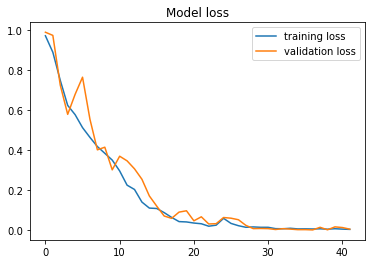

In [35]:
# plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Model loss')
plt.show() 

In [ ]:

# model.save('saved_model/my_model') 

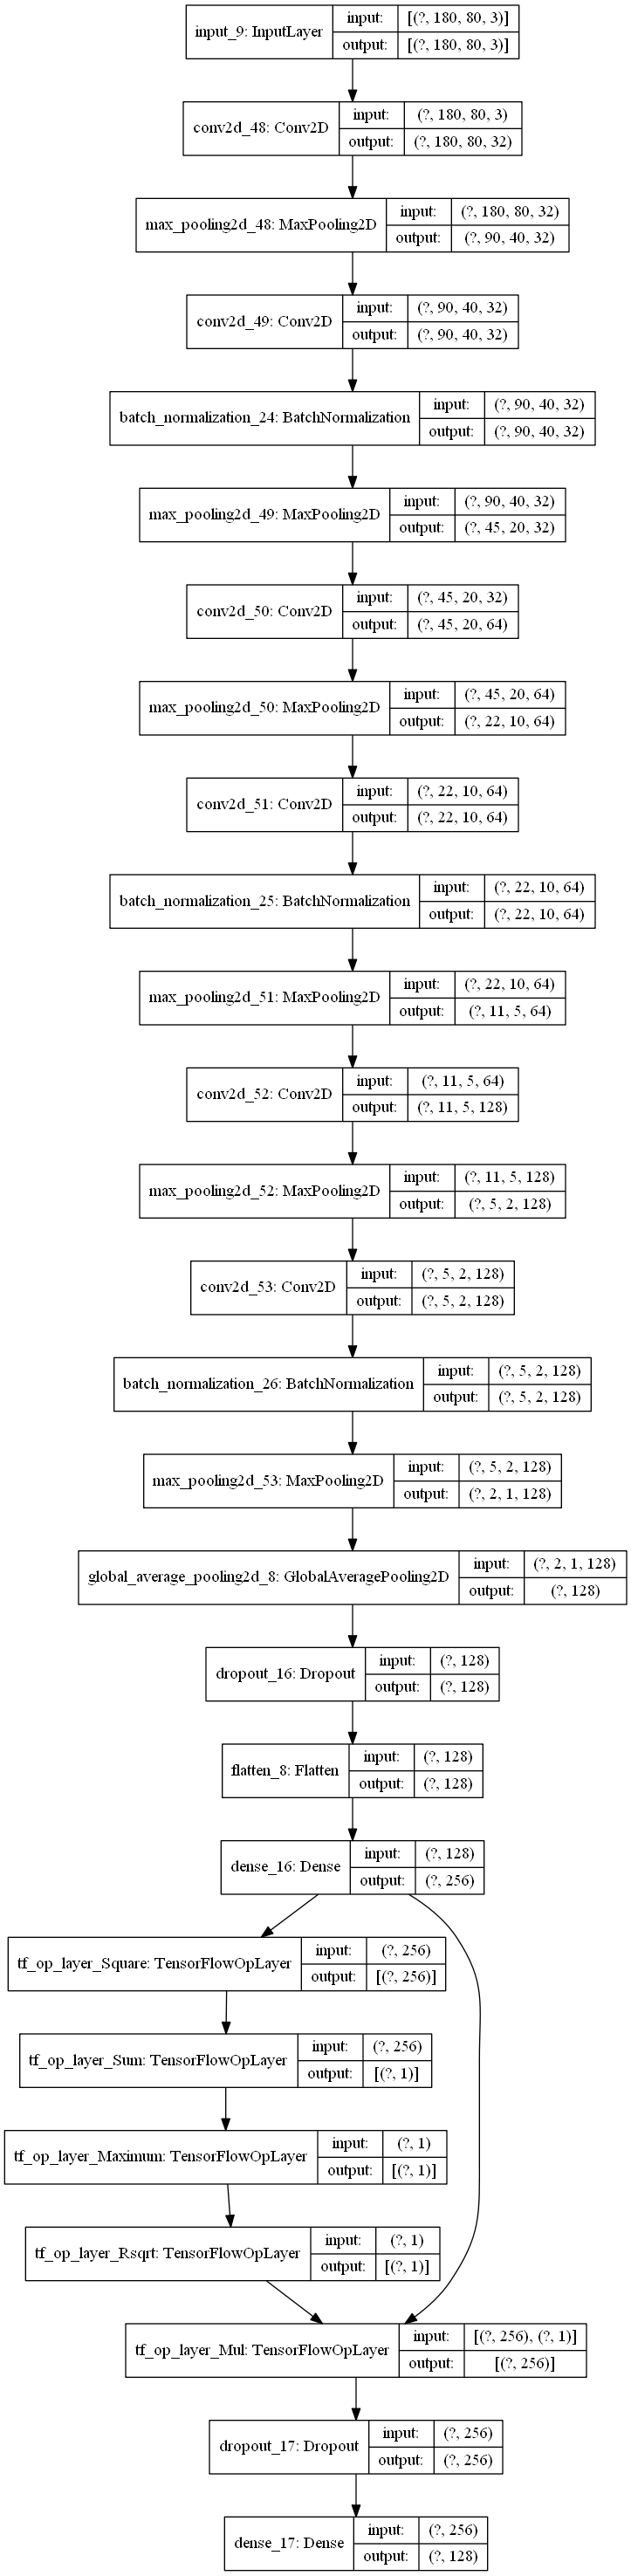

In [36]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Embeddings Visualization

In [62]:
x_test = x_val
y_test = y_val

In [63]:
#create an empty network
testing_embeddings2 = create_model(input_image_shape,128)
x_embeddings_before_train = testing_embeddings2.predict(np.reshape(x_test, (len(x_test), x_train.shape[1], x_train.shape[2],3)))

# for layer_target, layer_source in zip(testing_embeddings.layers, model.layers):
#     weights = layer_source.get_weights()
#     layer_target.set_weights(weights)
#     del weights

C:\Users\farha\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\farha\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


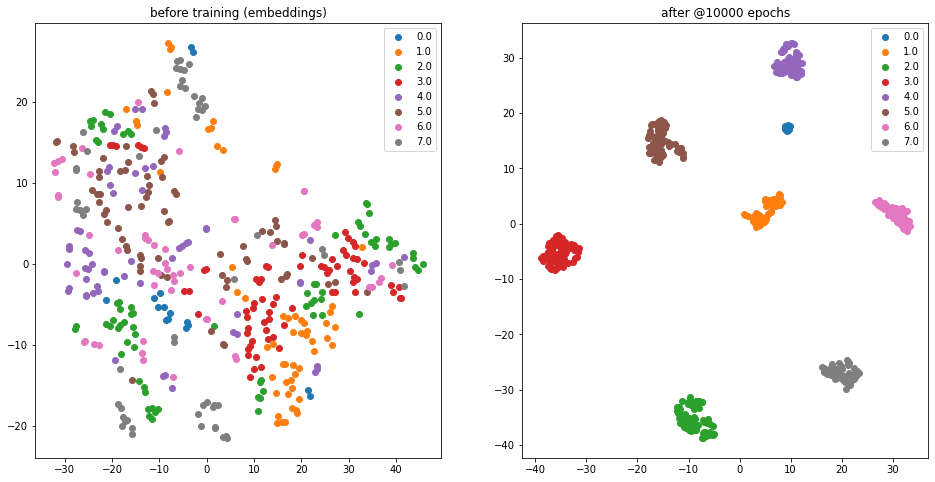

In [64]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
no_of_components = 2  # for visualization -> PCA.fit_transform()

step = 1
test_class_labels = np.unique(np.array(y_test))
model = create_model(input_image_shape,128)

model.load_weights("yt-triplet.hdf5")
# model = load_model("our_model_triplet_all.hdf5")
epochs = 10000
x_embeddings_before_train = testing_embeddings2.predict(np.reshape(x_test, (len(x_test), x_train.shape[1], x_train.shape[2],3)))

x_embeddings = model.predict(np.reshape(x_test, (len(x_test), x_train.shape[1], x_train.shape[2],3)))
pca = TSNE(n_components=2)
decomposed_embeddings = pca.fit_transform(x_embeddings)

decomposed_gray = pca.fit_transform(x_embeddings_before_train)

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    decomposed_embeddings_class = decomposed_embeddings[y_test == label]
    decomposed_gray_class = decomposed_gray[y_test == label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_gray_class[::step,1], decomposed_gray_class[::step,0],label=str(label))
    plt.title('before training (embeddings)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % epochs)
    plt.legend()

plt.show()

# CLASSIFIER

In [48]:
from tensorflow.keras.preprocessing import image

model = load_model('yt-triplet.hdf5',compile=False)

In [65]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 
import pickle
from sklearn.preprocessing import LabelEncoder
import numpy as np  
from sklearn.svm import SVC  
embedding_size =128

x_embeddings = model.predict(x_train)
y_embeddings = model.predict(x_val)

svc = SVC(kernel="linear",probability=True)
# param_grid = {'C': [0.1, 10, 100], 'gamma': [0.1,0.01,0.001],'kernel': ['rbf']}
# grid = GridSearchCV(svc,param_grid,refit=True,verbose=3)

le=LabelEncoder()
labels = le.fit_transform(y_train)
svc.fit(x_embeddings,labels)
valid_prediction = svc.predict(y_embeddings)
print("validation accuracy : ", accuracy_score(y_val, valid_prediction))

# with open("recognizer.pikle", "wb") as h:
#     pickle.dump(grid.best_estimator_, h)

validation accuracy :  1.0


In [66]:
print(classification_report(y_val, valid_prediction)) 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        16
         1.0       1.00      1.00      1.00        58
         2.0       1.00      1.00      1.00        77
         3.0       1.00      1.00      1.00        71
         4.0       1.00      1.00      1.00        62
         5.0       1.00      1.00      1.00        71
         6.0       1.00      1.00      1.00        56
         7.0       1.00      1.00      1.00        57

    accuracy                           1.00       468
   macro avg       1.00      1.00      1.00       468
weighted avg       1.00      1.00      1.00       468



# Save the embeddings and its label

In [39]:
with open("recognizer.pikle", "wb") as h:
    pickle.dump(svc, h)

In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(y_train)
# write the label encoder to disk
f = open("le.pickle", "wb")
f.write(pickle.dumps(le))
f.close()

In [ ]:
img_path = 'frame_42.png'
img = image.load_img(img_path, target_size=(180, 80))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_embeddings = model.predict(img_data)

preds = svc.predict_proba(img_embeddings)[0]
j = np.argmax(preds)
proba = preds[j]
name = le.classes_[j]
preds

In [ ]:
name

In [ ]:

valid_prediction = grid.predict(y_embeddings)

In [ ]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

In [ ]:

# import pickle

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(y_train)
# write the label encoder to disk
f = open("le.pickle", "wb")
f.write(pickle.dumps(le))
f.close()
# write the actual face recognition model to disk
f = open("x_embed.pickle", "wb")
f.write(pickle.dumps(x_embeddings))
f.close()
# write the actual face recognition model to disk
f = open("y_embed.pickle", "wb")
f.write(pickle.dumps(labels))
f.close()
# write the label encoder to disk
f = open("le.pickle", "wb")
f.write(pickle.dumps(le))
f.close()